# Project overview

### Why sentiment analysis? 

In this project product reviews (text data) will be classified into positive and negative so that sellers/manufacturers could have a better understanding of their product performance. The final classification model can be used as a "social listening tool" to classify tweets/statuses about certain products on social media, thereby having a quick overview of what people feel about them without conducting time-consuming and bias-prone opinion surveys. Sentiment analysis could also be applied to build product recommender systems that suggest new products based on their review sentiment. Since the dataset is collected on product reviews and not any other specific topics, our target audience is retailers and manufacturers.

### The dataset

The dataset used includes 10,000 customer reviews on Amazon products with labels indicating whether they are negative (1) or positive (2). The data is available for public use and could be accessed [here](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). A sneak peek of the dataset:

In [0]:
#df.head()

,text,label
9953,"boooooorrring!!!!: until now, there was some d...",1
3850,the sword in the stone: there are parts in the...,1
4962,a product with error.: the first day i bought ...,1
3886,a return to early trout: closer to the truth i...,2
5437,canon nb-5l battery for canon camera: i purcha...,2


# Data preparation

In [0]:
# libraries
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from nltk.corpus import stopwords

import xgboost, textblob, string
import re
import nltk
import string

In [0]:
# load the dataset
data = open('corpus', encoding='utf8').read()
labels, texts = [], []
for i, line in enumerate(data.split("\n")):
    content = line.split()
    labels.append(content[0])
    texts.append(" ".join(content[1:]).lower())
    
# Extract train labels  
def return_label(string):
    label = re.findall('\d', string)
    if label is not None:
        return int(label[0])

    
# create a dataframe using texts and lables
df = pd.DataFrame()
df['text'] = texts
df['label'] = labels
df['label'] = df['label'].apply(lambda row: return_label(row))

# shuffle the dataset
df = df.sample(frac=1, random_state=1)
df.head()

,text,label
9953,"boooooorrring!!!!: until now, there was some d...",1
3850,the sword in the stone: there are parts in the...,1
4962,a product with error.: the first day i bought ...,1
3886,a return to early trout: closer to the truth i...,2
5437,canon nb-5l battery for canon camera: i purcha...,2


# Exploratory data analysis

1    1212
2    1128
Name: label, dtype: int64


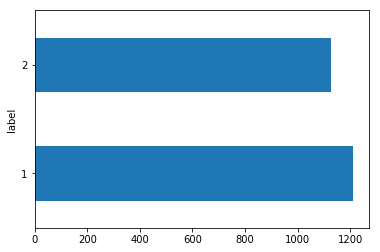

In [0]:
# class distribution (1=negative, 2=positive)
print(df['label'].value_counts())
df.groupby(['label']).size().plot(kind='barh')

The two label classes are equally distributed, so we don't have a class imbalance problem (which may require data resampling) here. The next step is plotting word frequency using word cloud with word size indicating the frequency level of that word. Before doing so, I remove stop words using a pre-built collection of English stop words - words that are frequent but not meaningful when it comes to understanding the context of the document, eg. pronouns like 'I', 'you', 'we', etc. and articles like 'the', 'a', 'an', etc. 

In [0]:
# remove stop words
import nltk
nltk.download('punkt')
stop = stopwords.words('english') 
text = nltk.word_tokenize(" ".join(df['text'].tolist()))
cleanwords = [i for i in text if i not in stop and i.isalpha()]
print(cleanwords[:10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['get', 'dancing', 'pulse', 'single', 'galang', 'explodes', 'like', 'computerized', 'firebombs', 'quaking']


First off, let's see the word cloud of the whole corpus (both negative and positive):

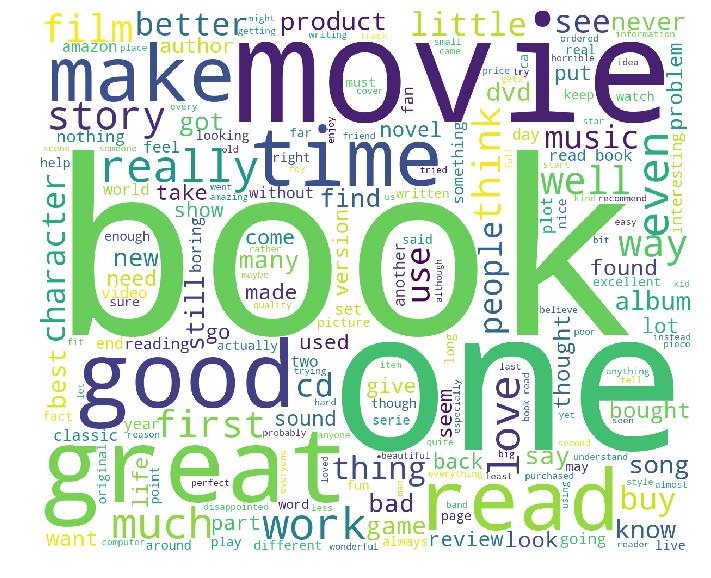

In [0]:
# prep the wordcloud
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords))

# plot
fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Next are the negative and positive clouds: 

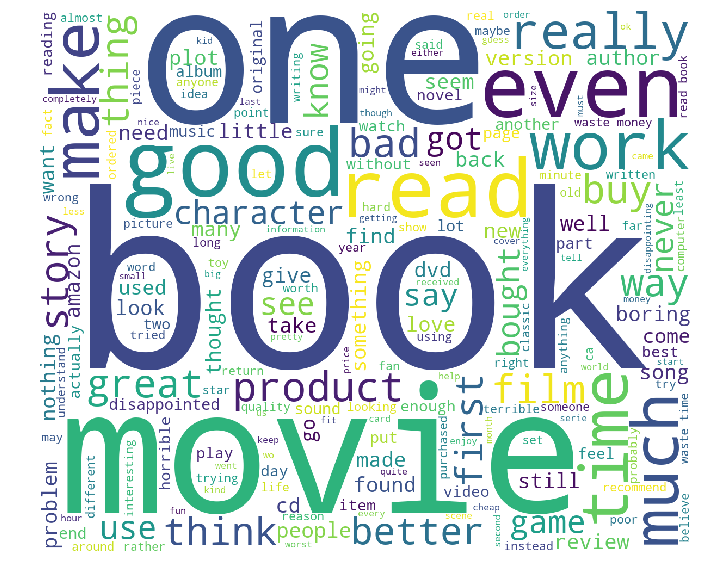

In [0]:
# wordcloud for negative reviews
df_neg = df[df['label']==1]
text_neg = nltk.word_tokenize(" ".join(df_neg['text'].tolist()))
cleanwords_neg = [i for i in text_neg if i not in stop and i.isalpha()]
wordcloud_neg = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords_neg))

fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

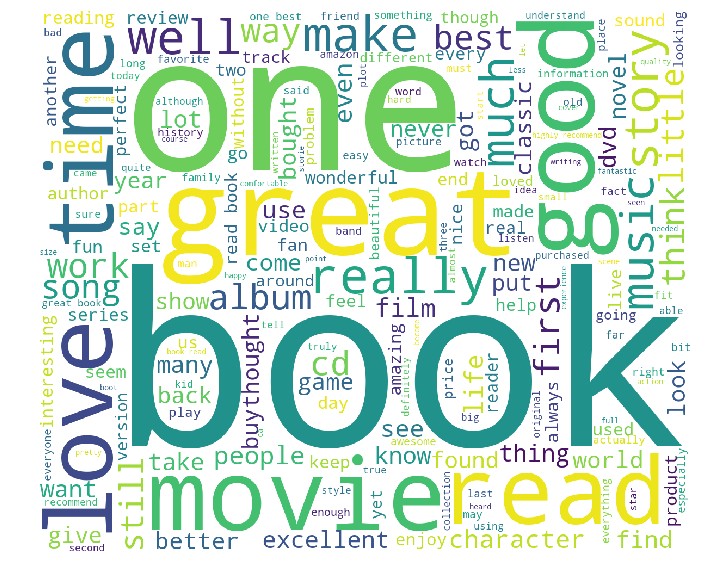

In [0]:
# wordcloud for positive reviews
df_pos = df[df['label']==2]
text_pos = nltk.word_tokenize(" ".join(df_pos['text'].tolist()))
cleanwords_pos = [i for i in text_pos if i not in stop and i.isalpha()]
wordcloud_pos = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords_pos))

fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

There is not much of a difference between the negative and positive word clouds. The most frequent words in both negative and positive reviews are always general ones like book, movie, read, love, etc., and these are not informative enough to explore or classify the reviews. A better approach to make more sense of the text is n-grams (words that frequently go together in the document). Here we have 2 plots of bigrams for negative and positive reviews: 

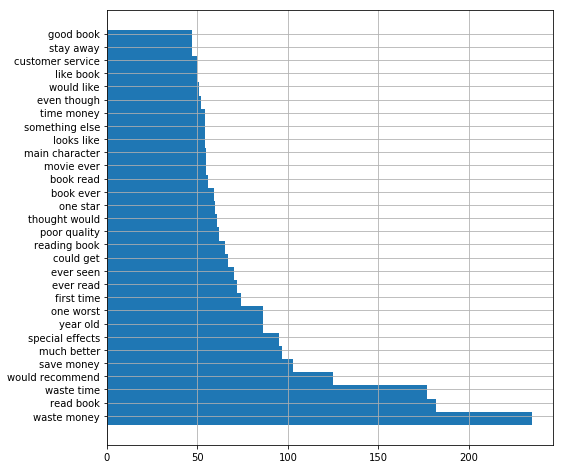

In [0]:
# negative reviews' bigrams
from collections import Counter
bigrams_neg = nltk.bigrams(cleanwords_neg)
counter_neg = Counter(bigrams_neg)
most_common_neg = sorted(counter_neg.most_common(30), key = lambda x: x[1], reverse=True)
labels = [" ".join(e[0]) for e in most_common_neg]
values = [e[1] for e in most_common_neg]
indexes = np.arange(len(labels))
width = 1
bigrams_fig = plt.figure(figsize = (8, 8))
plt.barh(indexes, values, width)

plt.yticks(indexes + width * 0.2, labels)
plt.grid()
plt.show()

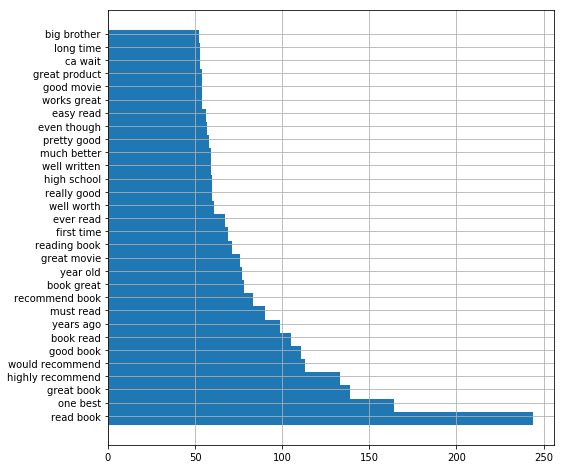

In [0]:
# positive reviews' bigrams
bigrams_pos = nltk.bigrams(cleanwords_pos)
counter_pos = Counter(bigrams_pos)
most_common_pos = sorted(counter_pos.most_common(30), key = lambda x: x[1], reverse=True)
labels = [" ".join(e[0]) for e in most_common_pos]
values = [e[1] for e in most_common_pos]
indexes = np.arange(len(labels))
width = 1
bigrams_fig = plt.figure(figsize = (8, 8))
plt.barh(indexes, values, width)

plt.yticks(indexes + width * 0.2, labels)
plt.grid()
plt.show()

The n-gram plot for negative reviews indicates that bad products often have problems with quality and customer service, and because most of them are books and movies (as seen in the word clouds), main characters play an important role in reviewers' judgement. 

However, while n-grams are more informative than single words, they are still overly general and don't give us enough insights. The reason is probably that common words are oftentimes less important than words that appear less frequently in the whole corpus but concentrate in a few documents/sentences of the corpus. This is why we need more advanced text transformations to penalize frequency, as discussed in the next section. 

# Feature engineering

For model building and evaluation, I split the corpus (full dataset) into 3 batches: train, validation and test. The reason why there are 3 batches instead of 2 (train and test only) is that in case we need to tune the models to get better results on the test set, test accuracy score is no longer a good measure of model performance because it's not unseen data. Therefore, we do all the model optimization work on another batch (the validation set) and measure model performance on the test set (now a separate batch that is not touched until the very end of the modeling process) to avoid data leakage and later on, overfitting. The train-validation-test sets have 7000, 2000 and 1000 rows respectively.  

The sentiment labels were given as 1 (negative) and 2 (positive) in the orginal dataset. To make it easier for predictive models to work, we transform them into 0 (negative) and 1 (positive). 

In [0]:
# split into train and test sets  
x_train, x_test, y_train, y_test = model_selection.train_test_split(df['text'], df['label'],
                                                                    test_size=0.3, random_state=1, shuffle=True)

# split into test and validation sets    
x_valid, x_test, y_valid, y_test = model_selection.train_test_split(x_test, y_test,
                                                                    test_size=1/3, random_state=1, shuffle=True)

# label encoded into 0 and 1 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.fit_transform(y_valid)
y_test = encoder.fit_transform(y_test)

To transform text data into numerical data, I use vector (Count Vectorizer) and matrix (word and n-gram level Term Frequency - Inverse Document Frequency) representation of the words/phrases present in product reviews. 

Count Vectorizer is a straight-forward transformation technique that basically one-hot encodes the reviews into a sparse matrix including 10,000 arrays of 1 (if the word is present in a review) and 0 (otherwise), using them as weights for the input data. 

In [0]:
# Count Vectorizer 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['text'])

xtrain_count = count_vect.transform(x_train)
xvalid_count = count_vect.transform(x_valid)
xtest_count = count_vect.transform(x_test)

Meanwhile, TF-IDF penalizes words that appear frequently and gives more weight to words that are less frequent but carry more meaning, so most of the time we will see better predictive results on datasets transformed with TF-IDF, as compared to Count Vectorizer. Here I test two TF-IDF methods, word level and n-gram (bigram and trigram) level to see which one works better. 

Word-level TF-IDF transforms the review word by word and hence, use single words as input features for learning algorithms. On the other hand, n-gram-level TF-IDF transforms by bigrams and trigrams, so it generates bigram and trigram features accordingly. 

In [0]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['text'])
xtrain_tfidf =  tfidf_vect.transform(x_train)
xvalid_tfidf =  tfidf_vect.transform(x_valid)
xtest_tfidf = tfidf_vect.transform(x_test)

# n-gram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(x_valid)
xtest_tfidf_ngram = tfidf_vect_ngram.transform(x_test)

# Model building

A `train_model` function is created to accelerate the model prototyping process. In this project, accuracy is selected as the main evaluation metric. 

In [0]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_label):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, valid_label)

For each ML classifier tested below, I will fit a model with default hyperparameters (parameters set by human rather than ones learned by the algorithm in the modeling process) and try multiple combinations of these hyperparameters using Random Search (for computational efficiency) and Regularization (to reduce overfitting) in sklearn to see which one returns the best accuracy score during cross validation. Neural network models are optimized using Stochastic Gradient Descent. The best hyperparameters found in the optimization process will be used to predict on the test set. 

### Support Vector Machines

The SVM algorithm seeks to find a hyperplane that best separates training examples into different classes so that the margin from the hyperplane to the nearest examples (support vectors) is maximized, which is equal to minimizing the following (loss) function: 

$$min_{L(w,b)}=\frac{1}{2}||w||_2^2+C\sum_{i=1}^n\zeta_i^k$$
subject to: $$y_{n}(w^{T}x_{n}+b)≥1−\zeta_{n}$$

where C is the hyperparameter that controls how much we penalize the error term $\zeta_{i}$. A smaller C indicates a smaller margin between 2 classes and less penalty on training errors. 

Another important hyperparameter of SVM is the kernel argument. SVM is commonly known as a linear classifier but we can tweak the hyperplane into a non-linear decision boundary using some kernel tricks. Apart from linear kernel (`linear`), we can test the model with polynomial (`poly`), radial basis function (`rbf`) and sigmoid (`sigmoid`) kernels to compare their performance. 

In [0]:
from sklearn.svm import SVC

# SVM model with default hyperparameters
svm = SVC(gamma = 'scale') # default gamma has been set to 'scale' in the latest version of sklearn
print("SVM, Count Vectorizer accuracy: ", train_model(svm, xtrain_count, y_train, xvalid_count, y_valid))
print("SVM, word-level TF-IDF accuracy:", train_model(svm, xtrain_tfidf, y_train, xvalid_tfidf, y_valid))
print("SVM, n-gram level TF-IDF accuracy: ", train_model(svm, xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram, y_valid))

SVM, Count Vectorizer accuracy:  0.846
SVM, word-level TF-IDF accuracy: 0.8725
SVM, n-gram level TF-IDF accuracy:  0.8435


Word-level TF-IDF gives the best validation accuracy, so I will be optimizing SVM models with this transformation. 

In [0]:
# see default parameters
svm.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>

Set a parameter grid with different combinations of C values and kernel methods:

In [101]:
from sklearn.model_selection import RandomizedSearchCV
# set param grid
svm_params = {'C':[0.1, 1, 10, 100, 1000], 'kernel':['linear', 'rbf', 'sigmoid', 'poly']}
svm_searcher = RandomizedSearchCV(svm, svm_params, cv=3, scoring='accuracy')
svm_searcher.fit(xtrain_tfidf, y_train)

print("Best CV params: ", svm_searcher.best_params_)
print("Best CV accuracy", svm_searcher.best_score_)

Best CV params:  {'kernel': 'rbf', 'C': 100}
Best CV accuracy 0.8657142857142858


See the final model's performance on the test set:

In [110]:
# use best params to form a tuned SVM model on test set, transformed with word-level TF-IDF 
svm_tuned = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, kernel='rbf', gamma='scale',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

svm_test = train_model(svm_tuned, xtrain_tfidf, y_train, xtest_tfidf, y_test)
print("Tuned SVM accuracy on test set: ", svm_test) 

Tuned SVM accuracy on test set:  0.866


### Logistic Regression

Logistic Regression estimates the probability a sample belongs to a label class using the sigmoid function. The LR algorithm finds the best model using the following objective (cost) function:

$$min_{J(\theta)} = \frac{1}{2m}\left[\sum_{i=1}^m(h_{\theta}(x^{i}) - y^{i})^2 + \lambda\sum_{j=1}^n \theta_j^2\right]$$
where $\lambda$ is the regularization term. 

I use hyperparamter $C$ as an inverse term of $\lambda$ with $C = 1/\lambda$. As $C$ increases, $\lambda$ decreases.
$\lambda$ controls the trade-off between allowing the model to increase its complexity as much as it can and keeping it simple enough to well generalize on new data. For example, with a large $C$ which means $\lambda$ being very small, the penalty is light and the model can increase its complexity (hence easily overfits itself to the training data) by assigning large weights to some certain features. On the other hand, with a small value of $C$, the model will tend to underfit as it becomes too simple to capture complex patterns. 

In [0]:
# LR model with default params
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg', n_jobs = 4)
print("Logistic Regression, Count Vectorizer accuracy: ", train_model(logreg, xtrain_count, y_train, xvalid_count, y_valid))
print("Logistic Regression, word-level TF-IDF accuracy: ", train_model(logreg, xtrain_tfidf, y_train, xvalid_tfidf, y_valid))
print("Logistic Regression, n-gram-level TF-IDF accuracy: ", train_model(logreg, xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram, y_valid))

Logistic Regression, Count Vectorizer accuracy:  0.857
Logistic Regression, word-level TF-IDF accuracy:  0.872
Logistic Regression, n-gram-level TF-IDF accuracy:  0.8405


In [0]:
# See default params 
logreg.get_param

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=4, penalty='l2',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)>

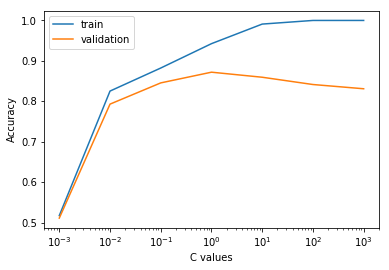

The best validation accuracy is  0.872 with C = 1


In [0]:
# Optimize Logreg model with word-level TF-IDF 
train_acc = []
valid_acc = []
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for C_value in C_values:
  lr = LogisticRegression(C=C_value, solver='newton-cg', multi_class='multinomial')
  lr.fit(xtrain_tfidf, y_train)
  train_acc.append(lr.score(xtrain_tfidf, y_train))
  valid_acc.append(lr.score(xvalid_tfidf, y_valid))
  
# Plot results
plt.semilogx(C_values, train_acc, C_values, valid_acc)
plt.legend(("train", "validation"))
plt.xlabel("C values")
plt.ylabel("Accuracy")
plt.show()

best_acc = valid_acc[valid_acc.index(max(valid_acc))]
best_C = C_values[valid_acc.index(max(valid_acc))]

print("The best validation accuracy is ", best_acc, "with C =", best_C)

It can be seen from the plot that as $C$ increases, the penalty given on training errors is lightened, making training accuracy increase. But if we keep optimizing for training accuracy, we will be overfitting the model to the training data and hence, reducing validation accuracy. The optimal point to end up with is the sweet spot at $C = 10^0 = 1$, which returns the highest validation accuracy. We already tested $C = 1$ in the default model so let's go with the default model. 

The Area Under the Curve (ROC-AUC) shows how good the model is at classifying the two classes. The closer the AUC score is to 1, the better it is. 

In [0]:
# check ROC curve - AUC
from sklearn.metrics import roc_auc_score
logreg_valid_pred = logreg.predict(xvalid_tfidf)
logreg_proba = logreg.predict_proba(xvalid_tfidf)[:, 1]
auc = roc_auc_score(y_valid, logreg_proba)
auc

0.9403544110351891

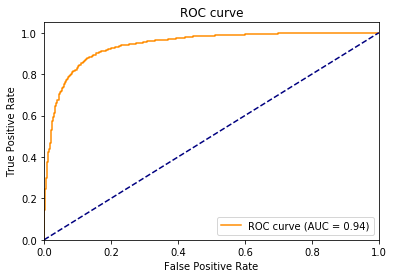

In [0]:
# plot the ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_valid, logreg_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

See the final model's performance on the test set: 

In [0]:
# tuned model is the same with default model because C remains the same
logreg_test = train_model(logreg, xtrain_tfidf, y_train, xtest_tfidf, y_test)
print("Logistic Regression accuracy on test set: ", logreg_test)

Logistic Regression accuracy on test set:  0.861


### k-Nearest Neighbors

kNN is a simple distance-based technique that stores distance data rather than fitting data or making real predictions. kNN classifies data points based on the majority of votes from their k nearest neighbors, so the most important hyperparameter to optimize for is the number of neighbors. 

In [0]:
from sklearn.neighbors import KNeighborsClassifier

# kNN model with default parameters 
knn = KNeighborsClassifier(n_neighbors = 3) # let's set k = 3
print("kNN, Count Vectorizer accuracy: ", train_model(knn, xtrain_count, y_train, xvalid_count, y_valid))
print("kNN, word-level TF-IDF accuracy: ", train_model(knn, xtrain_tfidf, y_train, xvalid_tfidf, y_valid))
print("kNN, n-gram-level TF-IDF accuracy: ", train_model(knn, xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram, y_valid))

kNN, Count Vectorizer accuracy:  0.6495
kNN, word-level TF-IDF accuracy:  0.7055
kNN, n-gram-level TF-IDF accuracy:  0.5065


Again, word-level TF-IDF gives the best validation accuracy, so I will optimize using this transformation.

Let's plot the accuracy score with respect to a range of k. Generally, accuracy increases as the number of neighbors increases but a large k would be computationally expensive. Here I set k from 1 to 80 with step 2 to make sure it's an odd number (easier to vote) and lies within an acceptable range. 

The optimal number of neighbors is 75


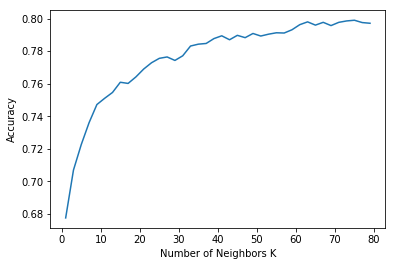

In [0]:
# kNN model tuning 

## create an odd list of K for KNN
neighbors = list(range(1, 80, 2)) # range 1:80 with step 2

## empty list that will hold cv scores
cv_scores = []

## perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xtrain_tfidf, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
## list of accuracy
knn_acc = [x for x in cv_scores]

## determine best k
optimal_k = neighbors[knn_acc.index(max(knn_acc))]
print("The optimal number of neighbors is {}".format(optimal_k))

## plot misclassification error vs k
plt.plot(neighbors, knn_acc)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Accuracy")
plt.show()

The plot shows that accuracy would be the highest with k=75, so I use this value to make prediction on the test set. 

In [0]:
# Use the tuned model on test set
knn_tuned = KNeighborsClassifier(n_neighbors = 75)
knn_test = train_model(knn_tuned, xtrain_tfidf, y_train, xtest_tfidf, y_test)
print("kNN tuned, word-level TF-IDF accuracy on test set: ", knn_test)

kNN tuned, word-level TF-IDF accuracy on test set:  0.785


### Random Forest

Random Forest is an ensemble method that combines multiple weak learners (Decision Trees) into a single model to determine class labels based on the majority of votes from all trees in the forest. RF offers a lot of hyperparameters that we can customize, including:

* `max_depth`: maximum number of levels in a tree
* `n_estimators`: number of trees in the forest
* `max_features`: number of features to consider when looking for the best split
* `min_samples_leaf`: minimum number of samples required at each leaf node
* `min_samples_split`: minimum number of samples required at each split,

among others. For fast experimentation, we would go with `max_depth`, `min_samples_leaf` and `min_samples_split`. 

In [0]:
# RF with default params
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500) # use default params 
print("Random Forest, Count Vectorizer accuracy: ", train_model(rf, xtrain_count, y_train, xvalid_count, y_valid))
print("Random Forest, Word-level TF-IDF accuracy: ", train_model(rf, xtrain_tfidf, y_train, xvalid_tfidf, y_valid))
print("Random Forest, N-gram-level TF-IDF accuracy: ", train_model(rf, xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram, y_valid))

Random Forest, Count Vectorizer accuracy:  0.8415
Random Forest, Word-level TF-IDF accuracy:  0.8405
Random Forest, N-gram-level TF-IDF accuracy:  0.7895


In [0]:
# See default params
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

The default model on word-level level TF-IDF returns the best result, so I will optimize using Random Search on word-level TF-IDF features. The number of trees in the forest is set to 500. 3-fold cross validation is run to find the best values for the 3 selected hyperparameters. 

In [0]:
# RF model tuning 
param_grid = {'max_depth': list(range(5, 50)), 
              'min_samples_split': list(range(2, 20)),
              'min_samples_leaf': list(range(2, 20))}

# Create a random search object
random_rf = RandomizedSearchCV(
   estimator = RandomForestClassifier(n_estimators = 500),
   param_distributions = param_grid, n_iter = 5,
   scoring='accuracy', n_jobs=4, cv = 3, refit=True, return_train_score = True)

# Fit to the training data
random_rf.fit(xtrain_tfidf, y_train)

# Print the values used for both hyperparameters
print("RF CV best params: ", random_rf.best_params_)
print("RF CV best accuracy: ", random_rf.best_score_)

RF CV best params:  {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 15}
RF CV best accuracy:  0.8076923076923077


In [0]:
rf_tuned = RandomForestClassifier(n_estimators = 500, min_samples_split = 3, 
                                  min_samples_leaf = 2, max_depth = 15,
                                 bootstrap=True, class_weight=None, criterion='gini',
                                 max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_weight_fraction_leaf=0.0,
                                 n_jobs=4, oob_score=False, random_state=None,
                                 verbose=0, warm_start=False)

rf_test = train_model(rf_tuned, xtrain_tfidf, y_train, xtest_tfidf, y_test)
print("Tuned Random Forest model accuracy on test set: ", rf_test)

Tuned Random Forest model accuracy on test set:  0.805


Random Forest might be better suited for structured data (with lots of numerical/categorical features) than text data. 

### Gradient Boosting Machines

GBM combines multiple weak learners (decision trees) in a greedy manner by updating weights given to each tree based on previously built trees. Similar to Random Forest, GBM offers customizable hyperparameters like `min_samples_leaf`, `min_samples_split`, `max_depth`, etc. 

In [0]:
# GBM with default params
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
print("GBM, Count Vectorizer accuracy: ", train_model(gbm, xtrain_count, y_train, xvalid_count, y_valid))
print("GBM, Word-level TF-IDF accuracy: ", train_model(gbm, xtrain_tfidf, y_train, xvalid_tfidf, y_valid))
print("GBM, N-gram-level TF-IDF accuracy: ", train_model(gbm, xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram, y_valid))

GBM, Count Vectorizer accuracy:  0.8146186440677966
GBM, Word-level TF-IDF accuracy:  0.8040254237288136
GBM, N-gram-level TF-IDF accuracy:  0.7457627118644068


GBM performs better with Count Vectorizer transformation, so we will be optimizing GBM models with such features. 

In [0]:
# see default params
gbm.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

In [0]:
# GBM tuning 
## set up params grid 
parameter_grid = {'min_samples_leaf': list(range(1, 51)),
                  'max_depth': list(range(5, 50)), 
                  'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}

## Optimize with random search 
random_GBM_class = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(),
    param_distributions = parameter_grid,
    n_iter = 10,
    scoring='accuracy',
    n_jobs=4,
    cv = 10,
    refit=True,
    return_train_score = True)

## Fit the object to our data
random_GBM_class.fit(xtrain_count, y_train)

print("GBM best params: ", random_GBM_class.best_params_)
print("GBM best accuracy: ", random_GBM_class.best_score_)

GBM best params:  {'min_samples_leaf': 35, 'max_depth': 40, 'learning_rate': 1}
GBM best accuracy:  0.8075642965204236


In [104]:
# predict on test set transformed with Count Vectorizer
from sklearn.ensemble import GradientBoostingClassifier
gbm_tuned = GradientBoostingClassifier(min_samples_leaf=35, learning_rate=1, max_depth=40)
gbm_test = train_model(gbm_tuned, xtrain_count, y_train, xtest_count, y_test)
print("GBM, Count Vectorizer accuracy on test set: ", gbm_test)

GBM, Count Vectorizer accuracy on test set:  0.825


### Neural networks

In [0]:
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

# model building
nn = Sequential()
nn.add(Dense(300, activation = 'relu', input_shape=(xtrain_tfidf.shape[1],)))
nn.add(Dense(300, activation = 'relu'))
nn.add(Dense(300, activation = 'relu'))
nn.add(Dense(300, activation = 'relu'))
nn.add(Dense(300, activation = 'relu'))
nn.add(Dense(300, activation = 'relu'))
nn.add(Dense(300, activation = 'relu'))
nn.add(Dense(1, activation = 'sigmoid'))
nn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
nn.fit(xtrain_tfidf, y_train, epochs = 20, validation_split = 0.3, callbacks = [early_stopping_monitor])

# model validation
nn_preds = nn.predict(xvalid_tfidf)
nn_preds = nn_preds.argmax(axis=-1)
print("Neural Networks accuracy on validation set: ", metrics.accuracy_score(nn_preds, y_valid))

Train on 4900 samples, validate on 2100 samples
Epoch 1/20
4900/4900 [==============================] - 7s 1ms/step - loss: 0.4703 - acc: 0.7731 - val_loss: 0.3331 - val_acc: 0.8567
Epoch 2/20
4900/4900 [==============================] - 6s 1ms/step - loss: 0.1339 - acc: 0.9496 - val_loss: 0.4005 - val_acc: 0.8400
Epoch 3/20
4900/4900 [==============================] - 6s 1ms/step - loss: 0.0244 - acc: 0.9916 - val_loss: 0.6859 - val_acc: 0.8371
Neural Networks accuracy on validation set:  0.506


Optimize with Stochastic Gradient Descent, iterating over a list of learning rates from 0.00001 to 1. 

In [0]:
from keras.optimizers import SGD 

# early stopping monitor
early_stopping_monitor = EarlyStopping(patience=2)
  
# list of learning rate to test
lr_list = [0.00001, 0.00001, 0.0001, 0.001, 0.01, 1]

# Loop over learning rates
for lr in lr_list:
    print('\n\nTesting model with learning rate: %f\n'%lr )
    
    # Build new model to test, unaffected by previous models
    model = nn
    my_optimizer = SGD(lr=lr)
    model.compile(optimizer = my_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.fit(xtrain_tfidf, y_train, validation_split=0.3)
 



Testing model with learning rate: 0.000010

Train on 4900 samples, validate on 2100 samples
Epoch 1/1
4900/4900 [==============================] - 6s 1ms/step - loss: 0.0044 - acc: 0.9996 - val_loss: 0.6856 - val_acc: 0.8371


Testing model with learning rate: 0.000010

Train on 4900 samples, validate on 2100 samples
Epoch 1/1
4900/4900 [==============================] - 6s 1ms/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.6853 - val_acc: 0.8371


Testing model with learning rate: 0.000100

Train on 4900 samples, validate on 2100 samples
Epoch 1/1
4900/4900 [==============================] - 6s 1ms/step - loss: 0.0042 - acc: 0.9998 - val_loss: 0.6829 - val_acc: 0.8371


Testing model with learning rate: 0.001000

Train on 4900 samples, validate on 2100 samples
Epoch 1/1
4900/4900 [==============================] - 5s 1ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.6730 - val_acc: 0.8419


Testing model with learning rate: 0.010000

Train on 4900 samples, validate on 2100 sample

Learning rate 0.01 returns the best accuracy. Let's create a tuned modeling using `lr=0.001` and try it on the test set.

In [0]:
# test the tuned model
nn_tuned = get_new_model()
sgd = SGD(lr=0.01)
nn_tuned.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])    
nn_tuned.fit(xtrain_tfidf, y_train, validation_split=0.3, epochs = 5)

nn_tuned_preds = nn_tuned.predict(xtest_tfidf)
nn_predictions = nn_tuned_preds.argmax(axis=-1)

nn_test = metrics.accuracy_score(nn_predictions, y_test)
print("Tuned Neural Networks accuracy on test set: ", nn_test)

Train on 4900 samples, validate on 2100 samples
Epoch 1/5
4900/4900 [==============================] - 6s 1ms/step - loss: 0.6931 - acc: 0.5094 - val_loss: 0.6929 - val_acc: 0.5105
Epoch 2/5
4900/4900 [==============================] - 4s 795us/step - loss: 0.6928 - acc: 0.5114 - val_loss: 0.6927 - val_acc: 0.5105
Epoch 3/5
4900/4900 [==============================] - 4s 793us/step - loss: 0.6927 - acc: 0.5114 - val_loss: 0.6927 - val_acc: 0.5105
Epoch 4/5
4900/4900 [==============================] - 4s 773us/step - loss: 0.6925 - acc: 0.5131 - val_loss: 0.6925 - val_acc: 0.5105
Epoch 5/5
4900/4900 [==============================] - 4s 800us/step - loss: 0.6923 - acc: 0.5114 - val_loss: 0.6922 - val_acc: 0.5105
Tuned Neural Networks accuracy on test set:  0.507


# Final thoughts

Summary of all models' performance:

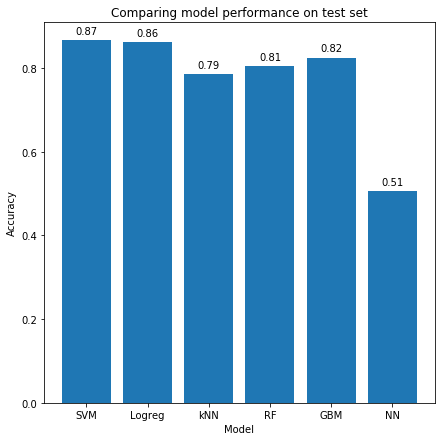

In [111]:
acc_list = [svm_test, logreg_test, knn_test, rf_test, gbm_test, nn_test]
model_name = ['SVM', 'Logreg', 'kNN', 'RF', 'GBM', 'NN']

plt.figure(figsize=(7,7))
plt.bar(model_name, acc_list)
plt.title('Comparing model performance on test set')
plt.xlabel('Model')
plt.ylabel('Accuracy')

for x,y in zip(model_name, acc_list):
    label = "{:.2f}".format(y)
    plt.annotate(label, 
                 (x,y),
                 textcoords='offset points', 
                 xytext=(0,6), 
                 ha='center') 

plt.show()

Overall, models designed for binary classification like Logistic Regression and SVM perform better than others. Meanwhile, kNN is not really a suitable model for NLP. RF and GBM models could be improved with a larger hyperparameter search space as many more parameters have not been tuned. For this problem, SVM is the best performer with an accuracy score of 0.87.